In [26]:
from PyPDF2 import PdfReader
import os
import pandas as pd
import glob

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

In [27]:
def get_pdfs_in_directory(directory_path):
    # Use glob to get all PDF files in the directory
    pdf_files = glob.glob(os.path.join(directory_path, '*.pdf'))
    return pdf_files
pdf_not_relevant = get_pdfs_in_directory('test_data/not_relevant')
pdf_relevant = get_pdfs_in_directory('test_data/relevant')

In [28]:
def text_extract(reader):
    doc_text = ""
    num_pages = len(reader.pages)
    for i in range(num_pages):
        page_text = reader.pages[i].extract_text() + " "
        doc_text += page_text
    return doc_text

def get_info(path,relevant):
    with open(path, 'rb') as f:
        pdf = PdfReader(f)
        info = pdf.metadata
        author = info.author if '/Author' in info else None
        title = info.title if '/Title' in info else None
        subject = info.subject if '/Subject' in info else None
        keywords = info['/Keywords'] if '/Keywords' in info else None
        number_of_pages = len(pdf.pages)
        text = text_extract(pdf)
        relevance = 1 if relevant else 0
    return [author, title, subject, keywords, number_of_pages, text, relevance]

In [29]:
all_info = []
for pdf in pdf_not_relevant:
	all_info.append(get_info(pdf,relevant = False))
for pdf in pdf_relevant:
	all_info.append(get_info(pdf,relevant = True))
harvest_nlp = pd.DataFrame(all_info,columns = ['author','title','subject','keywords','num_pages','text','is_relevant'])

In [30]:
harvest_nlp.head()

,author,title,subject,keywords,num_pages,text,is_relevant
0,ECDC,Effectiveness and cost-effectiveness of antena...,None,None,37,TECHNICAL REPORT\nEffectiveness and cost- \n...,0
1,None,None,None,None,45,SPECIAL REPORT\nImplementing the \nDublin Dec...,0
2,None,None,None,None,15,SPECIAL REPORT\nThematic report: \nSex worker...,0
3,None,None,None,None,36,TECHNICAL REPORT\nRisk assessment on HIV in G...,0
4,ECDC,Chlamydia - Annual epidemiological report,"Chlamydia, surveillance, monitoring","Chlamydia, surveillance, monitoring",9,\nSuggested citation: European Centre for Dis...,0


## Remove/Replace Nulls

In [31]:
harvest_nlp.isna().sum()

author         43
title          48
subject        56
keywords       50
num_pages       0
text            0
is_relevant     0
dtype: int64

In [32]:
len(harvest_nlp)

72

In [33]:
harvest_nlp.columns

Index(['author', 'title', 'subject', 'keywords', 'num_pages', 'text',
       'is_relevant'],
      dtype='object')

In [34]:
#replace empty strings with Unknown
harvest_nlp.replace('','Unknown',inplace=True)
harvest_nlp.replace(' ','Unknown',inplace=True)

#fill na values, drop ones that aren't necessary (only dropped one since there isn't too much data)
harvest_nlp.fillna({'author': 'Unknown',
						'title': 'Unknown',
						'subject': 'Unknown',
						'keywords': 'Unknown',
						},inplace=True)

In [35]:
harvest_nlp.isna().sum()

author         0
title          0
subject        0
keywords       0
num_pages      0
text           0
is_relevant    0
dtype: int64

In [36]:
harvest_nlp

,author,title,subject,keywords,num_pages,text,is_relevant
0,ECDC,Effectiveness and cost-effectiveness of antena...,Unknown,Unknown,37,TECHNICAL REPORT\nEffectiveness and cost- \n...,0
1,Unknown,Unknown,Unknown,Unknown,45,SPECIAL REPORT\nImplementing the \nDublin Dec...,0
2,Unknown,Unknown,Unknown,Unknown,15,SPECIAL REPORT\nThematic report: \nSex worker...,0
3,Unknown,Unknown,Unknown,Unknown,36,TECHNICAL REPORT\nRisk assessment on HIV in G...,0
4,ECDC,Chlamydia - Annual epidemiological report,"Chlamydia, surveillance, monitoring","Chlamydia, surveillance, monitoring",9,\nSuggested citation: European Centre for Dis...,0
...,...,...,...,...,...,...,...
67,ECDC,Dublin Declaration evidence brief: HIV testing...,"Dublin Declaration, HIV testing",HIV testing; Dublin Declaration; partnership t...,11,Suggested citation: HIV testing in Europe and ...,1
68,Fabrice Donguy,AER_template.docx,Unknown,Unknown,8,\n \n \nSuggested citation: European Centre f...,1
69,Rumila Edward,2024-WCP-0017 Draft.docx,Not specified,Communicable disease threats report,13,\n \nEuropean Centre for Disease Prevention a...,1
70,ECDC,Continuum of HIV care: 2022 progress report,HIV,HIV; continuum of HIV care; continuum of care;...,69,SPECIAL REPORT\nContinuum of HIV care\n \nMoni...,1


## Preprocessing/Cleaning

In [103]:
STOPWORDS = stopwords.words('english')
from spacy.lang.en import STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    patterns = {
        ### UNDERSTAND CONTEXT FIRST BEFORE CHANGING, HELPS TO MAKE MORE INFORMED DECISIONS
        #remove \n and \r and \t
        r'\n|\r|\t': ' ',

        #replaces 4-digit numbers starting with 1 or 2 with "year"
        r'\b[12]\d{3}\b':'year',
        
        }
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text)

    # remove punctuations
    puncs = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for p in puncs:
        text = text.replace(p,'') 
    
    # remove stopwords and make sure word length is greater than 2
    text = [word.lower() for word in text.split() if word.lower() not in STOP_WORDS and len(word)>1]

    text = [lemmatizer.lemmatize(word) for word in text]

    text = " ".join(text)

    return text

harvest_nlp['text_modified'] = harvest_nlp['text'].apply(lambda x: clean_text(x))

In [104]:
from collections import Counter

all_words = ' '.join(harvest_nlp['text_modified']).split()
word_counts = Counter(all_words)

def remove_low_high_occuring_words(text,low,high):
	words = text.split()
	new_text = " ".join(word for word in words if word_counts[word]>low and word_counts[word]<high)
	return new_text

#play around with this
harvest_nlp['text_modified'] = harvest_nlp['text_modified'].apply(lambda text: remove_low_high_occuring_words(text,100,500))

In [87]:
all_words = ' '.join(harvest_nlp['text_modified']).split()
word_counts = Counter(all_words)
print(sum(1 for value in word_counts.values() if value == 99))

0


things i need to experiment with
- thresholds for removign low/high occuring words
- feature engineering new features

- modeling tweaks to tfidf
- modeling tweaks to the randomforestmodel

In [109]:
harvest_nlp['author'].unique()

array(['ECDC', 'Unknown', 'Rumila Edward', 'Mapper', 'Uwe Kreisel',
       'jkleine', 'mStraetemans',
       'European Centre for Disease Prevention and Control',
       'Fabrice Donguy'], dtype=object)

## Modeling

In [204]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

#feature_columns = [col for col in harvest_nlp.columns if col !='text_modified' and col!='is_relevant']
feature_columns = ['num_pages']

preprocessor = ColumnTransformer(
	transformers=[
		('tfidf',TfidfVectorizer(max_features=3000),"text_modified"),
		('num',StandardScaler(),feature_columns)
    ],
	remainder='drop'
)

pipeline = Pipeline(steps = [
	('preprocessor',preprocessor),
	('classifier',GaussianNB())
])

In [205]:
features = harvest_nlp[['num_pages','text_modified']]
target = harvest_nlp['is_relevant']

X_train, X_test , y_train, y_test = train_test_split(features,target,
													 test_size=0.2,
													 random_state=42,
													 stratify=harvest_nlp['is_relevant'].values)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=3000),
                                                  'text_modified'),
                                                 ('num', StandardScaler(),
                                                  ['num_pages'])])),
                ('classifier', GaussianNB())])

In [206]:
pipeline.score(X_test,y_test)
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [195]:
y_test.values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [188]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.50      0.50      0.50         2

    accuracy                           0.87        15
   macro avg       0.71      0.71      0.71        15
weighted avg       0.87      0.87      0.87        15



In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


X_train, X_test , y_train, y_test = train_test_split(harvest_nlp['text_modified'].values,harvest_nlp['is_relevant'].values,
													 test_size=0.2,
													 random_state=42,
													 stratify=harvest_nlp['is_relevant'].values)

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000) #play around with this
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [51]:
from sklearn.model_selection import GridSearchCV

# play around with this too
param_grid = {
	'max_features':[None,"sqrt",0.2],
	'n_jobs': [-1],
	
}
rf=RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='f1')  
grid_search.fit(tfidf_train_vectors,y_train)   
print(grid_search.best_params_)

{'max_features': None, 'n_estimators': 1, 'n_jobs': -1}


In [52]:
y_pred = grid_search.predict(tfidf_test_vectors)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Test: Cosine Similarity
- finds the document that is the most similar and assigns it to that label
- works surprisingly well

In [139]:
from sklearn.metrics.pairwise import cosine_similarity

train_size = 0.8
X = harvest_nlp.drop('is_relevant',axis=1)
y = harvest_nlp['is_relevant']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=train_size,stratify=y,random_state=42)

train_data = X_train.copy()
train_data['is_relevant'] = y_train

test_data = X_test.copy()
test_data['is_relevant'] = y_test



In [182]:
vectorizer = TfidfVectorizer()
pretrained_vectors = vectorizer.fit_transform(train_data['text_modified'])

predictions = []
test_text = test_data['text_modified']
for text in test_text:
    new_vector = vectorizer.transform([text])
    similarity_scores = cosine_similarity(new_vector,pretrained_vectors)
    most_similar_index = np.argmax(similarity_scores)
    predicted_label = train_data[['text_modified','is_relevant']].iloc[most_similar_index]['is_relevant']
    predictions.append(predicted_label)
    print(f"Similarity Score: {similarity_scores[0][most_similar_index]:.3f}, Prediction: {predicted_label}")

Similarity Score: 0.259, Prediction: 0
Similarity Score: 0.757, Prediction: 0
Similarity Score: 0.591, Prediction: 0
Similarity Score: 0.483, Prediction: 0
Similarity Score: 0.842, Prediction: 1
Similarity Score: 0.662, Prediction: 0
Similarity Score: 0.439, Prediction: 0
Similarity Score: 0.448, Prediction: 0
Similarity Score: 0.651, Prediction: 1
Similarity Score: 0.487, Prediction: 0
Similarity Score: 0.728, Prediction: 0
Similarity Score: 0.490, Prediction: 0
Similarity Score: 0.457, Prediction: 0
Similarity Score: 0.920, Prediction: 1
Similarity Score: 0.131, Prediction: 0


In [152]:
predictions

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [154]:
test_data['is_relevant'].values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

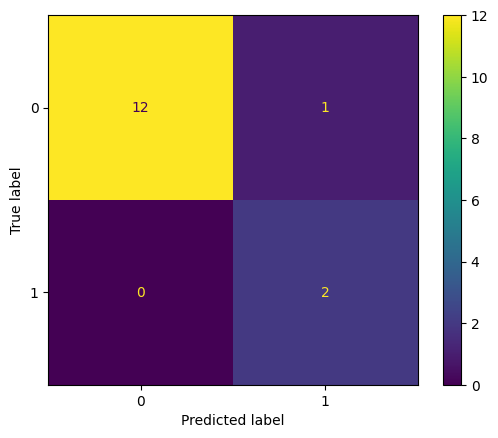

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_pred=predictions,y_true=test_data['is_relevant'].values)
disp = ConfusionMatrixDisplay(cm)
disp.plot()